# 6. Decision Trees and Ensemble Learning


This week, we'll talk about decision trees and tree-based ensemble algorithms

## 6.1 Credit risk scoring project

* Dataset: https://github.com/gastonstat/CreditScoring

In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## 6.2 Data cleaning and preparation

* Downloading the dataset
* Re-encoding the categorical variables
* Doing the train/validation/test split

In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv'

In [3]:
# !wget $data

In [4]:
# !head CreditScoring.csv

In [5]:
df = pd.read_csv(data)

In [6]:
df.columns = df.columns.str.lower()

In [7]:
df.status.value_counts()

status
1    3200
2    1254
0       1
Name: count, dtype: int64

In [8]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)

In [9]:
home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [10]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


In [11]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,763317.0,1060341.0,404382.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,8703625.0,10217569.0,6344253.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3500.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,166.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,99999999.0,99999999.0,99999999.0,5000.0,11140.0


In [12]:
# Missing values are coded as 99999999. Replace them as NaN
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=np.nan)

In [13]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4421.0,4408.0,4437.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,131.0,5403.0,343.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,86.0,11573.0,1246.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,120.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,165.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


In [14]:
#Remove 'unk' status values
df = df[df.status != 'unk'].reset_index(drop=True)

In [15]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

In [16]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [17]:
y_train = (df_train.status == 'default').astype('int').values
y_val = (df_val.status == 'default').astype('int').values
y_test = (df_test.status == 'default').astype('int').values

In [18]:
del df_train['status']
del df_val['status']
del df_test['status']

In [19]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,10,owner,36,36,married,no,freelance,75,0.0,10000.0,0.0,1000,1400
1,6,parents,48,32,single,yes,fixed,35,85.0,0.0,0.0,1100,1330
2,1,parents,48,40,married,no,fixed,75,121.0,0.0,0.0,1320,1600
3,1,parents,48,23,single,no,partime,35,72.0,0.0,0.0,1078,1079
4,5,owner,36,46,married,no,freelance,60,100.0,4000.0,0.0,1100,1897
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2667,18,private,36,45,married,no,fixed,45,220.0,20000.0,0.0,800,1600
2668,7,private,60,29,married,no,fixed,60,51.0,3500.0,500.0,1000,1290
2669,1,parents,24,19,single,no,fixed,35,28.0,0.0,0.0,400,600
2670,15,owner,48,43,married,no,freelance,60,100.0,18000.0,0.0,2500,2976


## 6.3 Decision trees

* How a decision tree looks like
* Training a decision tree 
* Overfitting
* Controlling the size of a tree

In [20]:
#Decision tree example
def assess_risk(client):
    if client['records'] == 'yes':        # root node (depth 0)
        if client['job'] == 'parttime':   # decision node (depth 1)
            return 'default'              # leaf node (depth 2)
        else:
            return 'ok'                   # leaf node
    else:
        if client['assets'] > 6000:       # decision node
            return 'ok'                   # leaf node
        else:
            return 'default'              # leaf node

In [21]:
xi = df_train.iloc[0].to_dict()

In [22]:
assess_risk(xi)

'ok'

### Training

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.tree import export_text

In [24]:
train_dicts = df_train.fillna(0).to_dict(orient='records')

In [25]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [26]:
#Training
#y_train == 'default' => class 0: 'not default', class 1: 'default'
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [27]:
val_dicts = df_val.fillna(0).to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [28]:
#dt.predict_proba(X_val) returns
#[probability of class 0, probability of class 1]
#[prob of not 'default', prob of 'default']
dt.predict_proba(X_val)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

In [29]:
#Validation
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6721289142912499

In [30]:
#Evaluate AUC on the training dataset
y_pred = dt.predict_proba(X_train)[:, 1]
roc_auc_score(y_train, y_pred)

1.0

### Overfitting

AUC = 1 => The model is overfitted.  
In DecisionTreeClassifier(), the max_depth parameter is set to None by default , allowing the tree to grow without restricting its depth. Consequently, the model may learn any possible combination of rules but may fail to generalize.

### Controlling the size of a decision tree

In [31]:
#Training model with max_depth=2
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [32]:
#Validation
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7054989859726213
val: 0.6685264343319367


In [33]:
#Visualize the decision tree rules with max_depth=2
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- class: 1
|   |--- seniority >  6.50
|   |   |--- class: 0
|--- records=no >  0.50
|   |--- job=partime <= 0.50
|   |   |--- class: 0
|   |--- job=partime >  0.50
|   |   |--- class: 1



## 6.4 Decision tree learning algorithm

* Finding the best split for one column
* Finding the best split for the entire dataset
* Stopping criteria
* Decision tree learning algorithm

### Node splitting using misclasification rate
The misclassification rate measures errors in predictions.

In [34]:
#Decision tree example with a single feature
data = [
    [8000, 'default'],
    [2000, 'default'],
    [   0, 'default'],
    [5000, 'ok'],
    [5000, 'ok'],
    [4000, 'ok'],
    [9000, 'ok'],
    [3000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'status'])
df_example

,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


In [35]:
df_example.sort_values('assets')

,assets,status
2,0,default
1,2000,default
7,3000,default
5,4000,ok
3,5000,ok
4,5000,ok
0,8000,default
6,9000,ok


In [36]:
#Tresholds
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [37]:
#Example for T = 4000
T = 4000
df_left = df_example[df_example.assets <= T] # default
df_right = df_example[df_example.assets > T] # ok

display(df_left)
print("Predicting 'default'")
print(df_left.status.value_counts(normalize=True))
display(df_right)
print("Predicting 'ok'")
print(df_right.status.value_counts(normalize=True))

,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


Predicting 'default'
status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


Predicting 'ok'
status
ok         0.75
default    0.25
Name: proportion, dtype: float64


- misclassification rate for 'default' (left): 0.25
- misclassification rate for 'ok' (right): 0.25
- average misclassification rate: 0.25

### Finding the best split

In [38]:
# from IPython.display import display

In [39]:
Ts = [0, 2000, 3000, 4000, 5000, 8000]

In [40]:
m_rate_default = []
m_rate_ok = []

In [41]:
for T in Ts:
    print("T =", T)
    df_left = df_example[df_example.assets <= T]
    df_right = df_example[df_example.assets > T]
    
    m_rate_left = df_left.status.value_counts(normalize=True)
    m_rate_right = df_right.status.value_counts(normalize=True)

    m_rate_default.append(m_rate_left.get('ok', 0))
    m_rate_ok.append(m_rate_right.get('default', 0))

    display(df_left)
    print(m_rate_left)
    display(df_right)
    print(m_rate_right)

    print()

T = 0


,assets,status
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
1,2000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

T = 2000


,assets,status
1,2000,default
2,0,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok
7,3000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

T = 3000


,assets,status
1,2000,default
2,0,default
7,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
5,4000,ok
6,9000,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

T = 4000


,assets,status
1,2000,default
2,0,default
5,4000,ok
7,3000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,status
0,8000,default
3,5000,ok
4,5000,ok
6,9000,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

T = 5000


,assets,status
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,status
0,8000,default
6,9000,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

T = 8000


,assets,status
0,8000,default
1,2000,default
2,0,default
3,5000,ok
4,5000,ok
5,4000,ok
7,3000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,status
6,9000,ok


status
ok    1.0
Name: proportion, dtype: float64



In [42]:
m_rate_mean = np.mean([m_rate_default, m_rate_ok], axis=0)

In [43]:
print('average misclasification rate')
for i in range(len(Ts)):
    print(f"T={Ts[i]}, {m_rate_mean[i]:.2f}")

average misclasification rate
T=0, 0.21
T=2000, 0.17
T=3000, 0.10
T=4000, 0.25
T=5000, 0.50
T=8000, 0.21


Best misclasification rate: 10% for T=3000

In [44]:
#Decision tree example with multiple features
data = [
    [8000, 3000, 'default'],
    [2000, 1000, 'default'],
    [   0, 1000, 'default'],
    [5000, 1000, 'ok'],
    [5000, 1000, 'ok'],
    [4000, 1000, 'ok'],
    [9000,  500, 'ok'],
    [3000, 2000, 'default'],
]

df_example = pd.DataFrame(data, columns=['assets', 'debt', 'status'])
df_example

,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


In [45]:
df_example.sort_values('debt')

,assets,debt,status
6,9000,500,ok
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default
0,8000,3000,default


In [46]:
thresholds = {
    'assets': [0, 2000, 3000, 4000, 5000, 8000],
    'debt': [500, 1000, 2000]
}

In [47]:
m_rate_default = []
m_rate_ok = []

In [48]:
for feature, Ts in thresholds.items():
    print('#####################')
    print(feature)
    
    m_rate_default_feat = []
    m_rate_ok_feat = []
    
    for T in Ts:
        print("T =", T)

        if(feature =='assets'):
            df_left = df_example[df_example[feature] <= T] #'default'
            df_right = df_example[df_example[feature] > T] #'ok'
        elif(feature == 'debt'):
            df_left = df_example[df_example[feature] > T] #'default'
            df_right = df_example[df_example[feature] <= T] #'ok'

        m_rate_left = df_left.status.value_counts(normalize=True)
        m_rate_right = df_right.status.value_counts(normalize=True)
   
        m_rate_default_feat.append(m_rate_left.get('ok', 0))
        m_rate_ok_feat.append(m_rate_right.get('default', 0))

        display(df_left)
        print(m_rate_left)
        display(df_right)
        print(m_rate_right)

        print()
    
    m_rate_default.append(m_rate_default_feat)
    m_rate_ok.append(m_rate_ok_feat)
    print('#####################')

#####################
assets
T = 0


,assets,debt,status
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

T = 2000


,assets,debt,status
1,2000,1000,default
2,0,1000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

T = 3000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.8
default    0.2
Name: proportion, dtype: float64

T = 4000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
5,4000,1000,ok
7,3000,2000,default


status
default    0.75
ok         0.25
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
3,5000,1000,ok
4,5000,1000,ok
6,9000,500,ok


status
ok         0.75
default    0.25
Name: proportion, dtype: float64

T = 5000


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.5
ok         0.5
Name: proportion, dtype: float64


,assets,debt,status
0,8000,3000,default
6,9000,500,ok


status
default    0.5
ok         0.5
Name: proportion, dtype: float64

T = 8000


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

#####################
#####################
debt
T = 500


,assets,debt,status
0,8000,3000,default
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
7,3000,2000,default


status
default    0.571429
ok         0.428571
Name: proportion, dtype: float64


,assets,debt,status
6,9000,500,ok


status
ok    1.0
Name: proportion, dtype: float64

T = 1000


,assets,debt,status
0,8000,3000,default
7,3000,2000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok


status
ok         0.666667
default    0.333333
Name: proportion, dtype: float64

T = 2000


,assets,debt,status
0,8000,3000,default


status
default    1.0
Name: proportion, dtype: float64


,assets,debt,status
1,2000,1000,default
2,0,1000,default
3,5000,1000,ok
4,5000,1000,ok
5,4000,1000,ok
6,9000,500,ok
7,3000,2000,default


status
ok         0.571429
default    0.428571
Name: proportion, dtype: float64

#####################


In [49]:
print(m_rate_default)
print(m_rate_ok)

[[0, 0, 0, 0.25, 0.5, 0.42857142857142855], [0.42857142857142855, 0, 0]]
[[0.42857142857142855, 0.3333333333333333, 0.2, 0.25, 0.5, 0], [0, 0.3333333333333333, 0.42857142857142855]]


In [50]:
m_rate_mean = []
for i in range(len(m_rate_default)):
    m_rate_mean.append(np.mean([m_rate_default[i], m_rate_ok[i]], axis=0))

In [51]:
feature_names = list(thresholds.keys())
ts_values = list(thresholds.values())

print('average misclasification rate')
for i in range(len(feature_names)):
    print(feature_names[i])
    for j in range(len(ts_values[i])):
        print(f"T={ts_values[i][j]}, {m_rate_mean[i][j]:.2f}")

average misclasification rate
assets
T=0, 0.21
T=2000, 0.17
T=3000, 0.10
T=4000, 0.25
T=5000, 0.50
T=8000, 0.21
debt
T=500, 0.21
T=1000, 0.17
T=2000, 0.21


### Stopping criteria  
- Group already pure.
- Tree reached depth limit.
- Group too small to split.

### Decision tree learning algorithm: summary
- Find the best split.
- Stop if max_depth is reached.
- If left is sufficiently large and not pure yet, then repeat for left.
- If right is sufficiently large and not pure yet, then repeat for right.

## 6.5 Decision trees parameter tuning

* selecting `max_depth`
* selecting `min_samples_leaf` (The minimum number of samples required to be at a leaf node).


In [52]:
#Training models with different values of max_depth
depths = [1, 2, 3, 4, 5, 6, 10, 15, 20, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    
    y_pred = dt.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    print('%4s -> %.3f' % (depth, auc))

   1 -> 0.606
   2 -> 0.669
   3 -> 0.739
   4 -> 0.761
   5 -> 0.767
   6 -> 0.759
  10 -> 0.682
  15 -> 0.672
  20 -> 0.652
None -> 0.655


Best scores for depth in [4, 5, 6]

In [53]:
#Training models with different values of min_samples_leaf
scores = []

for depth in [4, 5, 6]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)
        
        scores.append((depth, s, auc))

In [54]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [55]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc              
max_depth             4      5      6
min_samples_leaf                     
1                 0.761  0.767  0.759
5                 0.761  0.768  0.762
10                0.761  0.762  0.778
15                0.764  0.772  0.785
20                0.761  0.774  0.773
100               0.756  0.763  0.776
200               0.747  0.759  0.768
500               0.680  0.680  0.680

Best score (0.786) is obtained with a deeper tree (depth=6) and a small minimum number of samples at a leaf node (min_samples_leaf=15).

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

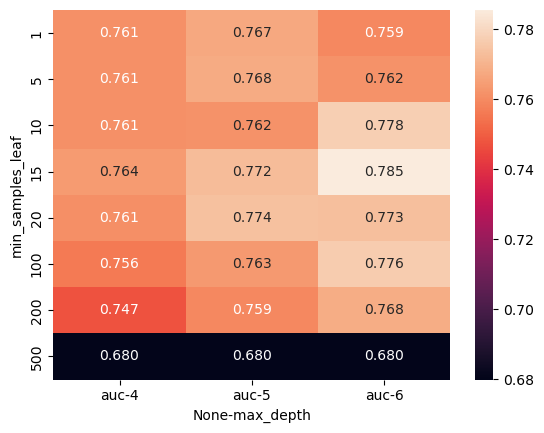

In [56]:
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

In [57]:
#Training final decision tree model
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [58]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- records=no <= 0.50
|   |--- seniority <= 6.50
|   |   |--- amount <= 862.50
|   |   |   |--- price <= 925.00
|   |   |   |   |--- amount <= 525.00
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- amount >  525.00
|   |   |   |   |   |--- class: 1
|   |   |   |--- price >  925.00
|   |   |   |   |--- price <= 1382.00
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- price >  1382.00
|   |   |   |   |   |--- class: 0
|   |   |--- amount >  862.50
|   |   |   |--- assets <= 8250.00
|   |   |   |   |--- job=fixed <= 0.50
|   |   |   |   |   |--- assets <= 3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- assets >  3425.00
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- job=fixed >  0.50
|   |   |   |   |   |--- age <= 31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |--- age >  31.50
|   |   |   |   |   |   |--- class: 1
|   |   |   |--- assets >  8250.00
|   |   |   |   |--- income <= 132.50
|   |   |   |   |   |--- class: 1
|

## 6.6 Ensembles and random forest

* Board of experts
* Ensembling models 
* Random forest - ensembling decision trees
* Tuning random forest

**Random Forest** is an ensemble learning method that combines the predictions of multiple decision trees to improve predictive accuracy and reduce overfitting.

The **randomness** is introduced by two aspects: data sampling and feature selection. 

**Random Subset of Features:** When creating each split in a decision tree, Random Forest considers only a random subset of the available features rather than using all the features. This is typically referred to as "feature bagging" or "feature selection." It helps reduce the correlation between the trees and ensures that not every tree relies on the same set of features.

**Random sampling of data:** Instead of using the entire dataset to build each decision tree, Random Forest randomly selects a subset of the data with replacement. This is known as **bootstrapping** or bagging. This random sampling introduces diversity in the training data for each tree.

In [59]:
from sklearn.ensemble import RandomForestClassifier

In [60]:
#Training models with different values of n_estimators
scores = []

for n in range(10, 201, 10):
    # n_estimators = number of models or trees
    rf = RandomForestClassifier(n_estimators=n, random_state=1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    
    scores.append((n, auc))

In [61]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])

Text(0, 0.5, 'AUC score')

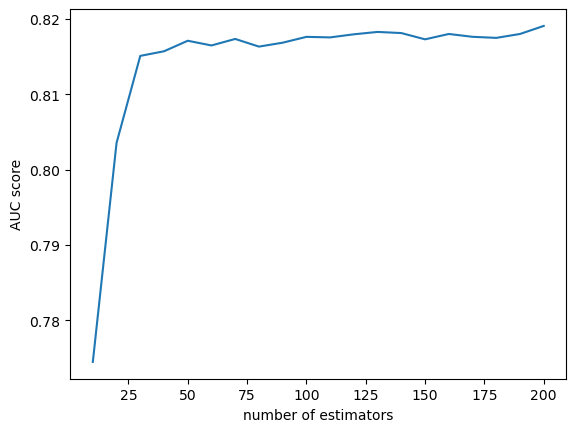

In [62]:
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.xlabel("number of estimators")
plt.ylabel("AUC score")

Best AUC score at ~50 trees.

In [63]:
#Training models with different values of max_depth
scores = []

for d in [5, 10, 15]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

In [64]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores.head()

,max_depth,n_estimators,auc
0,5,10,0.787699
1,5,20,0.797731
2,5,30,0.800305
3,5,40,0.799708
4,5,50,0.799878


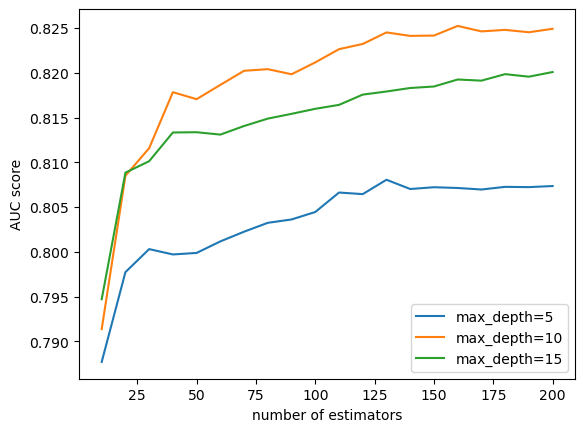

In [65]:
for d in [5, 10, 15]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)
    plt.xlabel("number of estimators")
    plt.ylabel("AUC score")

plt.legend()

Best AUC score at max_depth=10

In [66]:
max_depth = 10

In [67]:
#Training models with different values of min_samples_leaf
scores = []

for s in [1, 3, 5, 10, 50]:
    for n in range(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((s, n, auc))

In [68]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

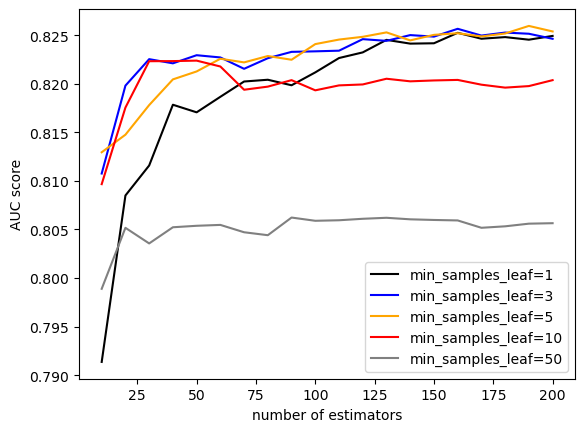

In [69]:
colors = ['black', 'blue', 'orange', 'red', 'grey']
values = [1, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             color=col,
             label='min_samples_leaf=%d' % s)
    plt.xlabel("number of estimators")
    plt.ylabel("AUC score")

plt.legend()

Best AUC score at min_samples_leaf=3

In [70]:
min_samples_leaf = 3

In [71]:
#Training final random forest model
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)

rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

Other useful parametes:

* `max_features`: The number of features to consider when looking for the best split.
* `bootstrap` (bool, default=True): If False, the whole dataset is used to build each tree.
* `n_jobs`: The number of jobs to run in parallel.

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

## 6.7 Gradient boosting and XGBoost

* Gradient boosting vs random forest
* Installing XGBoost
* Training the first model
* Performance monitoring
* Parsing xgboost's monitoring output

While Random Forest allows for parallel training, Gradient boosting trains models sequentially.  
In Gradient boosting, the final model is an ensemble of multiple trees. Each boosting stage adds a new tree to address the errors or residuals made by the ensemble of trees built so far. The final prediction is obtained by combining the predictions of all the trees in the ensemble. 

In [72]:
# !pip install xgboost

In [73]:
import xgboost as xgb

In [74]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

### Training with default parameters
https://xgboost.readthedocs.io/en/latest/parameter.html

In [75]:
xgb_params = {
    'eta': 0.3, #learning rate
    'max_depth': 6, #Maximum depth of a tree
    'min_child_weight': 1, #similar to min_samples_leaf
    
    'objective': 'binary:logistic',
    'nthread': 8, #Number of parallel threads used to run XGBoost
    
    'seed': 1,
    'verbosity': 1, #Verbosity of printing messages
}

# num_boost_round => Number of boosting iterations.
model = xgb.train(xgb_params, dtrain, num_boost_round=10)

In [76]:
y_pred = model.predict(dval)

In [77]:
roc_auc_score(y_val, y_pred)

0.8065256351262986

In [78]:
# evals => List of validation sets for which metrics will evaluated during training
watchlist = [(dtrain, 'train'), (dval, 'val')]

Add an evaluation metric at each boosting stage:

In [79]:
%%capture output 
#saves evaluation logs as 'output'

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

#Print evaluation scores every 'verbose_eval' boosting stages
model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5, evals=watchlist)

In [80]:
s = output.stdout

In [81]:
print(s[:200])

[0]	train-auc:0.86730	val-auc:0.77938
[5]	train-auc:0.93086	val-auc:0.80858
[10]	train-auc:0.95447	val-auc:0.80851
[15]	train-auc:0.96554	val-auc:0.81334
[20]	train-auc:0.97464	val-auc:0.81729
[25]	tr


In [82]:
#Extract scores from 'output'
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [83]:
df_score = parse_xgb_output(output)
df_score.head()

,num_iter,train_auc,val_auc
0,0,0.86730,0.77938
1,5,0.93086,0.80858
2,10,0.95447,0.80851
3,15,0.96554,0.81334
4,20,0.97464,0.81729


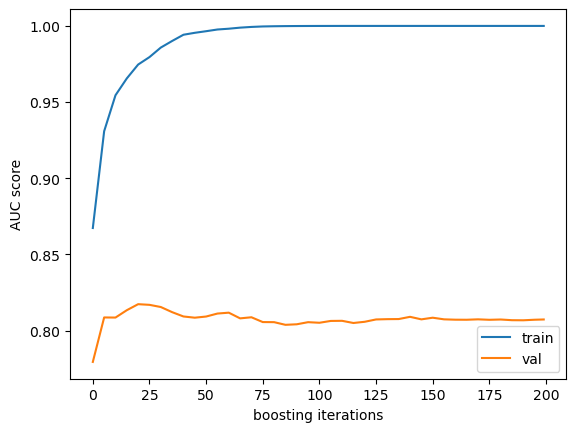

In [84]:
#Plot evaluation scores
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.xlabel("boosting iterations")
plt.ylabel("AUC score")
plt.legend()

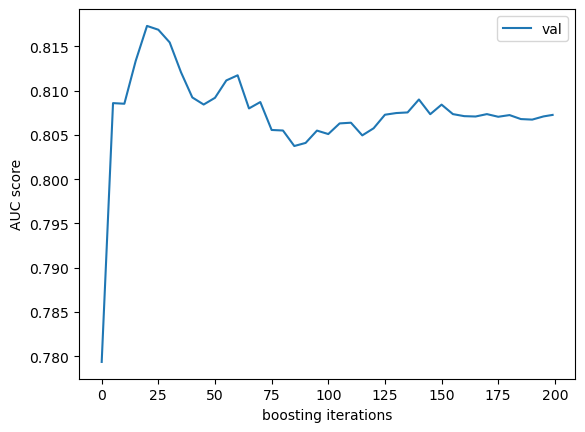

In [85]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.xlabel("boosting iterations")
plt.ylabel("AUC score")
plt.legend()

## 6.8 XGBoost parameter tuning

Tuning the following parameters:

* `eta`: learning rate
* `max_depth`: Maximum depth of a tree
* `min_child_weight`: similar to min_samples_leaf

* `eta`: learning rate

For each boosting stage, the **gradient** of the loss with respect to the predictions provides both the direction and magnitude of the adjustment required to reduce the loss. In simpler terms, using the eta (**learning rate**) and the gradient, the adjustment to make to the predictions during each boosting stage should be calculted as follows:    
`predictions at current stage = predictions at previous stage - (eta * gradient at current stage)`

### eta (learning rate)

In [86]:
scores = {}

In [87]:
etas = [0.01, 0.05, 0.1]

In [88]:
%%capture output

for eta in etas:    
    xgb_params = {
        'eta': eta, 
        'max_depth': 6,
        'min_child_weight': 1,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [89]:
parse_output = parse_xgb_output(output)
rows_per_eta = len(parse_output) // len(etas)

for i, eta in enumerate(etas): 
    key = 'eta=%s' % (eta)
    start_row = i * rows_per_eta
    end_row = (i + 1) * rows_per_eta
    scores[key] = parse_output[start_row:end_row]

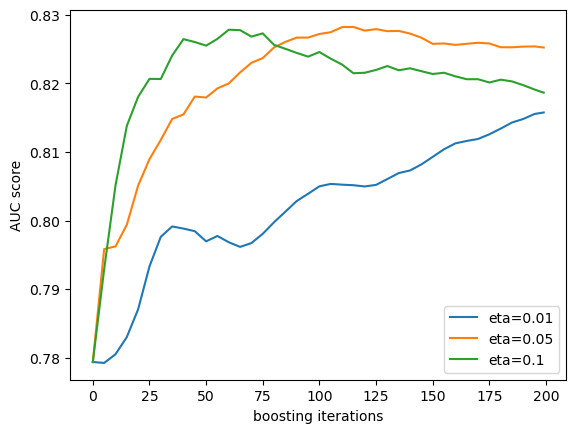

In [90]:
for key, df_score in list(scores.items()):
    plt.plot(df_score.num_iter, df_score.val_auc, label=key)

plt.xlabel('boosting iterations')
plt.ylabel('AUC score')
plt.legend()

Best AUC score at ~60 iterations with an eta of 0.1

### max_depth

In [91]:
scores = {}

In [92]:
max_depths = [3, 4, 6, 10]

In [93]:
%%capture output

for max_depth in max_depths:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': max_depth,
        'min_child_weight': 1,
 
        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [94]:
parse_output = parse_xgb_output(output)
rows_per_depth = len(parse_output) // len(max_depths)

for i, max_depth in enumerate(max_depths): 
    key = 'max_depth=%s' % (max_depth)
    start_row = i * rows_per_depth
    end_row = (i + 1) * rows_per_depth
    scores[key] = parse_output[start_row:end_row]

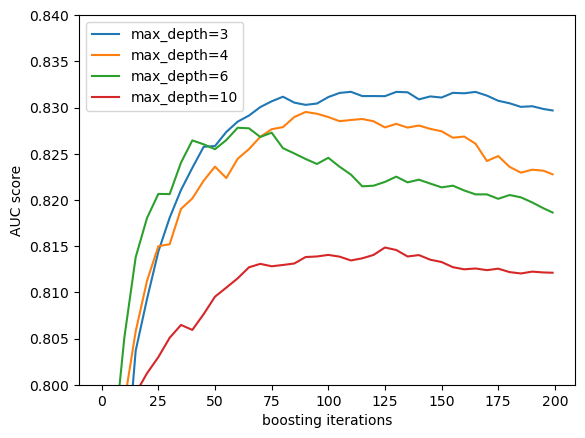

In [95]:
for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.xlabel('boosting iterations')
plt.ylabel('AUC score')
plt.ylim(0.8, 0.84)
plt.legend()

Best AUC score at ~175 iterations with a max_depth of 3

### min_child_weight

In [96]:
scores = {}

In [97]:
min_child_weights = [1, 10, 30]

In [98]:
%%capture output

for min_child_weight in min_child_weights:
    xgb_params = {
        'eta': 0.1, 
        'max_depth': 3,
        'min_child_weight': min_child_weight,

        'objective': 'binary:logistic',
        'eval_metric': 'auc',

        'nthread': 8,
        'seed': 1,
        'verbosity': 1,
    }

    model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                      verbose_eval=5,
                      evals=watchlist)

In [99]:
parse_output = parse_xgb_output(output)
rows_per_weight = len(parse_output) // len(min_child_weights)

for i, min_child_weight in enumerate(min_child_weights): 
    key = 'min_child_weight=%s' % (min_child_weight)
    start_row = i * rows_per_weight
    end_row = (i + 1) * rows_per_weight
    scores[key] = parse_output[start_row:end_row]

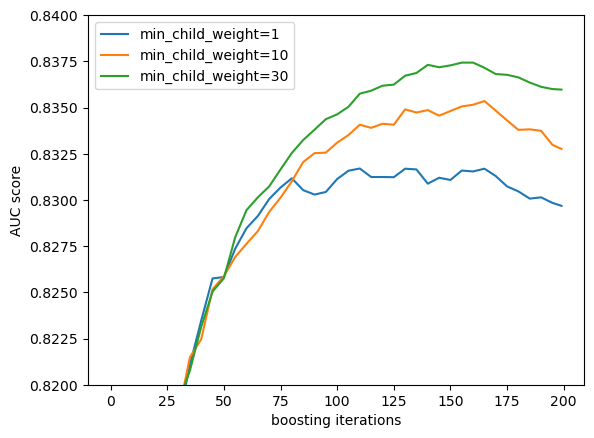

In [100]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.xlabel('boosting iterations')
plt.ylabel('AUC score')
plt.ylim(0.82, 0.84)
plt.legend()

Best AUC score at ~160 iterations with a min_child_weight of 30

In [101]:
#Training final XGboost model
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

Other parameters: https://xgboost.readthedocs.io/en/latest/parameter.html

Useful ones:

* `subsample` and `colsample_bytree`
* `lambda` and `alpha`

## 6.9 Selecting the final model

* Choosing between xgboost, random forest and decision tree
* Training the final model
* Saving the model

### Decision tree

In [102]:
dt = DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=6, min_samples_leaf=15)

In [103]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.7854738320699426

### Random forest

In [104]:
rf = RandomForestClassifier(n_estimators=200,
                            max_depth=10,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=3, n_estimators=200,
                       random_state=1)

In [105]:
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8246258264512848

### XGBoost

In [106]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=175)

In [107]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.8309347073212081

### Training final model with full dataset

In [108]:
df_full_train = df_full_train.reset_index(drop=True)

In [109]:
y_full_train = (df_full_train.status == 'default').astype(int).values

In [110]:
del df_full_train['status']

In [111]:
dicts_full_train = df_full_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [112]:
features = list(dv.get_feature_names_out())

dfulltrain = xgb.DMatrix(X_full_train, label=y_full_train,
                    feature_names=features)

dtest = xgb.DMatrix(X_test, feature_names=features)

In [113]:
xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 1,

    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dfulltrain, num_boost_round=175)

In [114]:
y_pred = model.predict(dtest)

In [115]:
roc_auc_score(y_test, y_pred)

0.8289367577342261

## 6.10 Summary

* Decision trees learn if-then-else rules from data.
* Finding the best split: select the least impure split. This algorithm can overfit, that's why we control it by limiting the max depth and the size of the group.
* Random forest is a way of combininig multiple decision trees. It should have a diverse set of models to make good predictions.
* Gradient boosting trains model sequentially: each model tries to fix errors of the previous model. XGBoost is an implementation of gradient boosting. 

## 6.11 Explore more

* For this dataset we didn't do EDA or feature engineering. You can do it to get more insights into the problem.
* For random forest, there are more parameters that we can tune. Check `max_features` and `bootstrap`.
* There's a variation of random forest caled "extremely randomized trees", or "extra trees". Instead of selecting the best split among all possible thresholds, it selects a few thresholds randomly and picks the best one among them. Because of that extra trees never overfit. In Scikit-Learn, they are implemented in `ExtraTreesClassifier`. Try it for this project.
* XGBoost can deal with NAs - we don't have to do `fillna` for it. Check if not filling NA's help improve performance.
* Experiment with other XGBoost parameters: `subsample` and `colsample_bytree`.
* When selecting the best split, decision trees find the most useful features. This information can be used for understanding which features are more important than otheres. See example here for [random forest](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html) (it's the same for plain decision trees) and for [xgboost](https://stackoverflow.com/questions/37627923/how-to-get-feature-importance-in-xgboost)
* Trees can also be used for solving the regression problems: check `DecisionTreeRegressor`, `RandomForestRegressor` and the `objective=reg:squarederror` parameter for XGBoost.